## Genere obras de arte impresionantes con la difusión guiada CLIP

Sin duda, la creatividad humana puede considerarse el componente más indispensable de cada gran hazaña que hayamos logrado. A lo largo de los años se han utilizado ampliamente modelos generativos profundos para imitar esta habilidad, y es evidente que estos modelos mejoran cada día como resultado de los frecuentes logros en la investigación. Exploremos las capacidades creativas de estos modelos y profundicemos en cómo podemos utilizar los modelos generativos profundos, en combinación con modelos generalizados de visión y lenguaje, para crear hermosas obras de arte de diversos estilos a partir de indicaciones de texto en lenguaje natural.

Analizaremos cómo ajustar los **modelos probabilísticos de difusión** en un conjunto de datos personalizado creado a partir de obras de arte de dominio público. Durante el **proceso de muestreo para generar imágenes**, utilizaremos un **modelo CLIP** de lenguaje de visión para dirigir o guiar este modelo ajustado con indicaciones de lenguaje natural, sin **ningún entrenamiento o supervisión adicional**. Después, **las imágenes generadas se ampliarán a un tamaño mayor mediante el uso de un modelo de superresolución basado en transformadores Swin**, que convierte la salida generada de baja resolución en una imagen de alta resolución al generar detalles realistas más finos y mejorar la calidad visual. También cubriremos brevemente los conceptos detrás del funcionamiento interno de cada uno de estos modelos y más detalles sobre su integración en breve.

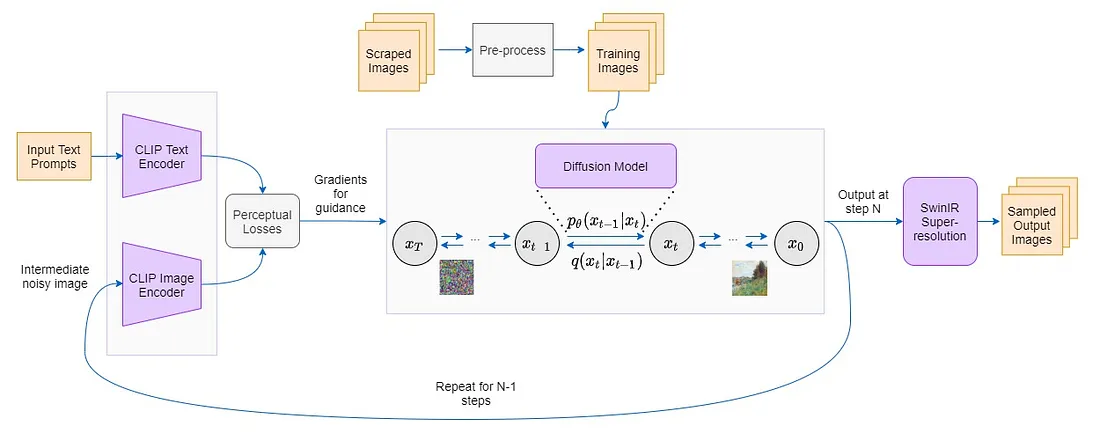

Veamos un ejemplo: 

"Pintura de acuarela vibrante de una flor, Artstation HQ" (imagen del autor)
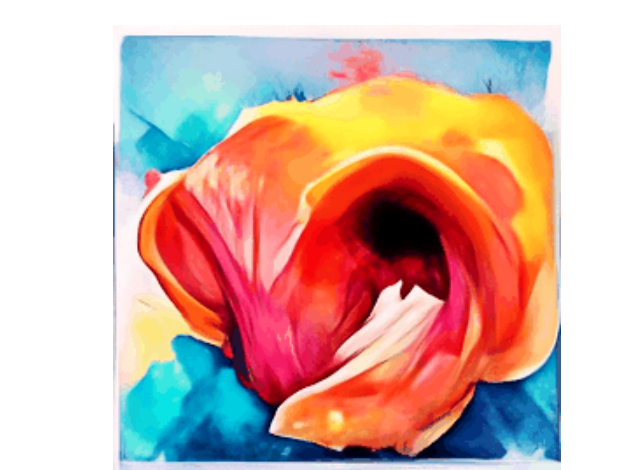

Utilizaremos **arquitecturas de modelos de difusión** y **procedimientos de entrenamiento** de los artículos Improved Denoising Diffusion Probabilistic Models y Diffusion Models Beat GANs de Dhariwal y Nichol, 2021 (OpenAI), donde los autores han mejorado la **verosimilitud logarítmica para maximizar el aprendizaje de todos los modos de distribución de datos**, y otras **métricas generativas como FID (Fréchet Inception Distance) e IS (Inception Score), para mejorar la fidelidad de la imagen generada**. El **modelo** que utilizaremos **tiene una arquitectura de red neuronal basada en la columna vertebral de PixelCNN++**, que es una U-Net basada en una Wide ResNet **con normalización de grupo en lugar de normalización de peso**, para simplificar la implementación. **Estos modelos tienen dos bloques residuales convolucionales por nivel de resolución y utilizan bloques de autoatención de múltiples cabezales con una resolución de 16x16 y una resolución de 8x8 entre los bloques convolucionales**. El **tiempo de difusión t** se especifica añadiendo la incrustación de posición sinusoidal del transformador en cada bloque residual.

Existen otras complejidades para comprender los modelos de difusión, con muchas mejoras en la literatura reciente, que serían difíciles de resumir en un artículo breve. Para una mejor comprensión teórica y detalles sobre la implementación, recomiendo leer los artículos sobre modelos de difusión. Al momento de escribir este artículo, el recuento total de artículos sobre modelos de difusión no es tan abrumador como el número de artículos sobre GAN.

### CLIP 
CLIP (Contrastive Language–Image Pre-training) ha establecido un punto de referencia en las áreas de zero-shot transfer, supervisión del lenguaje natural y aprendizaje multimodal, mediante el entrenamiento en una amplia variedad de imágenes y supervisión del lenguaje. Estos modelos no se entrenan directamente para optimizar los puntos de referencia de tareas singulares, lo que los hace mucho menos miopes en cuanto a los conceptos visuales y lingüísticos aprendidos. Esto condujo a un mejor rendimiento en comparación con varios modelos supervisados ​​entrenados con ImageNet, incluso superando al ResNet50 original sin ser entrenado explícitamente en ninguna de las 1,28 millones de muestras etiquetadas. CLIP se ha utilizado en una amplia variedad de tareas desde que se introdujo en enero de 2021.

A CLIP se le puede mostrar una imagen o pedirle que realice una tarea (como categorizar algo) para la que no fue entrenado directamente, pero aún así puede lograr hacerlo razonablemente bien porque ha aprendido conceptos generales de su entrenamiento.

Por ejemplo, si le das a CLIP una imagen de una cebra y le pides que la identifique como "cebra", incluso si no fue entrenado específicamente para reconocer cebras, aún puede descifrarla usando lo que sabe sobre animales similares o conceptos visuales.
Esto se llama **"zero-shot"** porque el modelo está realizando la tarea sin haber visto ejemplos de esa tarea durante el entrenamiento.

Los autores utilizaron un gran conjunto de datos creado con alrededor de 400 millones de pares de imágenes y texto para el entrenamiento. En cada iteración, un lote de N pares de texto e imágenes se envía a través de un **codificador de imágenes y texto**, que se entrena conjuntamente para maximizar la similitud de coseno de las incrustaciones de texto e imagen de los N pares reales (en los elementos diagonales del espacio de incrustación multimodal representado en la figura siguiente), al tiempo que minimiza las puntuaciones de similitud de los otros $N^2−N$ elementos (presentes en las posiciones no diagonales) en el espacio de incrustación, para formar un objetivo de entrenamiento contrastivo. Se utiliza una pérdida de entropía cruzada simétrica para optimizar el modelo en estas puntuaciones de similitud.


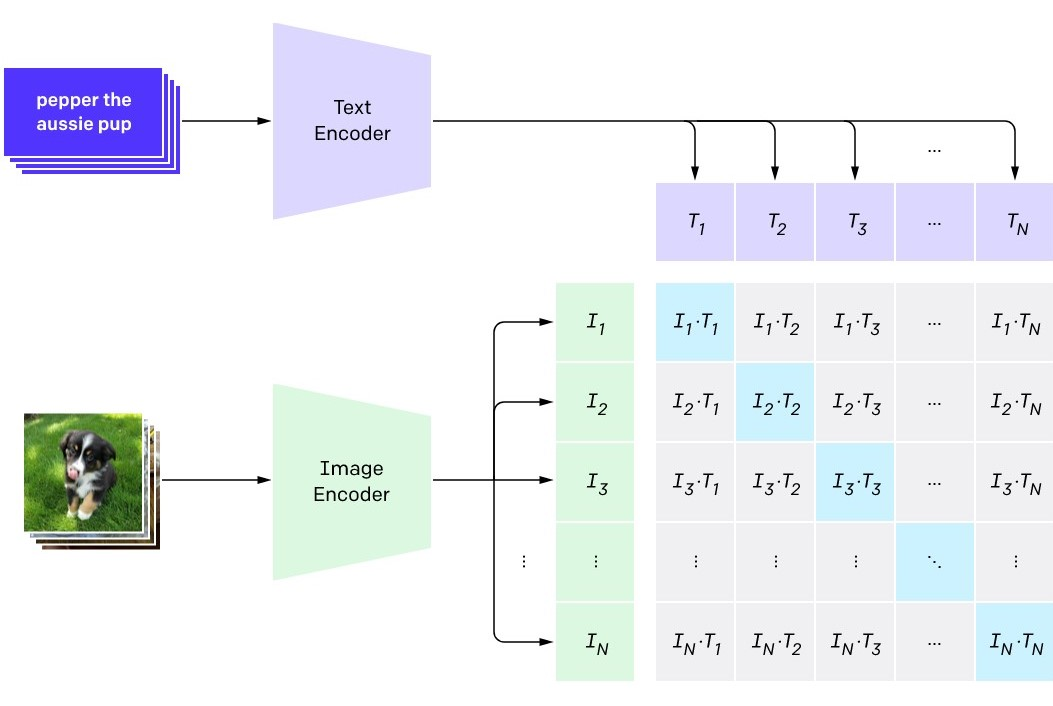

Utilizaremos CLIP para dirigir el proceso de eliminación de ruido del muestreo de imágenes de los modelos de difusión, para producir muestras que coincidan con el mensaje de texto proporcionado como condición. Esta técnica se ha utilizado en trabajos como DALL-E y GLIDE, y también para guiar otros modelos generativos como VQGAN, StyleGAN2 y Siren (redes de representación sinusoidal), por nombrar algunos. Este procedimiento de guía se realiza codificando primero la imagen de salida intermedia del modelo de difusión durante el proceso de muestreo iterativo con el cabezal codificador de imágenes CLIP, mientras que los mensajes de texto se convierten en incrustaciones utilizando el cabezal codificador de texto. Luego, la imagen de salida resultante y las incrustaciones de texto se utilizan para calcular una pérdida perceptiva, que mide la similitud entre las dos incrustaciones. Los gradientes con respecto a esta pérdida y la imagen intermedia eliminada de ruido se utilizan para acondicionar o guiar el modelo de difusión durante el proceso de muestreo para producir la siguiente imagen intermedia eliminada de ruido. Este proceso se repite hasta que se completen todos los pasos de muestreo. También utilizamos pérdidas para controlar el suavizado espacial, como la variación total y las pérdidas de rango, así como los aumentos de imagen, para mejorar la calidad. Además de esto, también se toman múltiples recortes de imágenes en lotes para minimizar el objetivo de pérdida, lo que genera mejoras en la calidad de la síntesis y un uso optimizado de la memoria al muestrear desde GPU más pequeñas.

Para la parte de CLIP, utilizaremos la dependencia https://github.com/sreevishnu-damodaran/clip-diffusion-art/tree/main/clip_diffusion_art y las funciones de logger, train.TrainLoop, cda_utils.args_to_dict, cda_utils.add_dict_to_argparser. Para este notebook no entraremos en gran detalle para cada función por lo que solo daremos una brede descripción de lo que hará cada uno. 

In [5]:
!git status

"git" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [4]:
!git clone https://github.com/sreevishnu-damodaran/clip-diffusion-art.git -q



"git" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
